In [14]:
import geopandas
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
import spaghetti
from haversine import haversine
import pandas as pd
import numpy as np
import networkx as nx
import osmnx
import random
from matplotlib import pyplot as plt
import seaborn as sns
import esda
import warnings

warnings.filterwarnings("ignore")

Center Latitude: 53.809128400000006, Longitude: -1.5302367852524053.


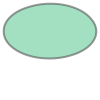

In [15]:
# From Lab8 https://github.kcl.ac.uk/k2143309/7CUSMNDA-2023
PLACE_OF_INTEREST = "Leeds City Centre, Leeds, United Kingdom"
leeds_center = osmnx.geocode_to_gdf(PLACE_OF_INTEREST, buffer_dist=1000)
leeds_polygon = leeds_center['geometry'][0]

print("Center Latitude: {}, Longitude: {}.".format(leeds_center.lat.values[0],leeds_center.lon.values[0]))
leeds_polygon

In [16]:
USE_COLS = ['Grid Ref: Easting', 'Grid Ref: Northing']

year_list = ["2017","2018","2019"]
# read the data from csv files and store them in a list
leeds = []
for i in range(len(year_list)):
    leeds_df = pd.read_csv("data/Leeds_RTC_"+ year_list[i] +'.csv',encoding='ISO-8859-1')
    leeds.append(leeds_df)
# merge into one dataframe
leeds_df = pd.concat(leeds, axis=0, ignore_index=True)
leeds_df = leeds_df.dropna(subset=USE_COLS)

In [17]:
gdf = geopandas.GeoDataFrame(
    leeds_df, geometry=geopandas.points_from_xy(leeds_df["Grid Ref: Easting"], leeds_df["Grid Ref: Northing"],crs="EPSG:27700"))
gdf=gdf.to_crs(epsg=4326).drop(['Grid Ref: Northing','Grid Ref: Easting'],axis=1)

# get the accident points with their position.
accident = gdf.geometry
# Limit Accident Points to chosen area
leeds_accident = gdf[accident.within(leeds_polygon)]
len(leeds_accident)

379

The network is planar: True


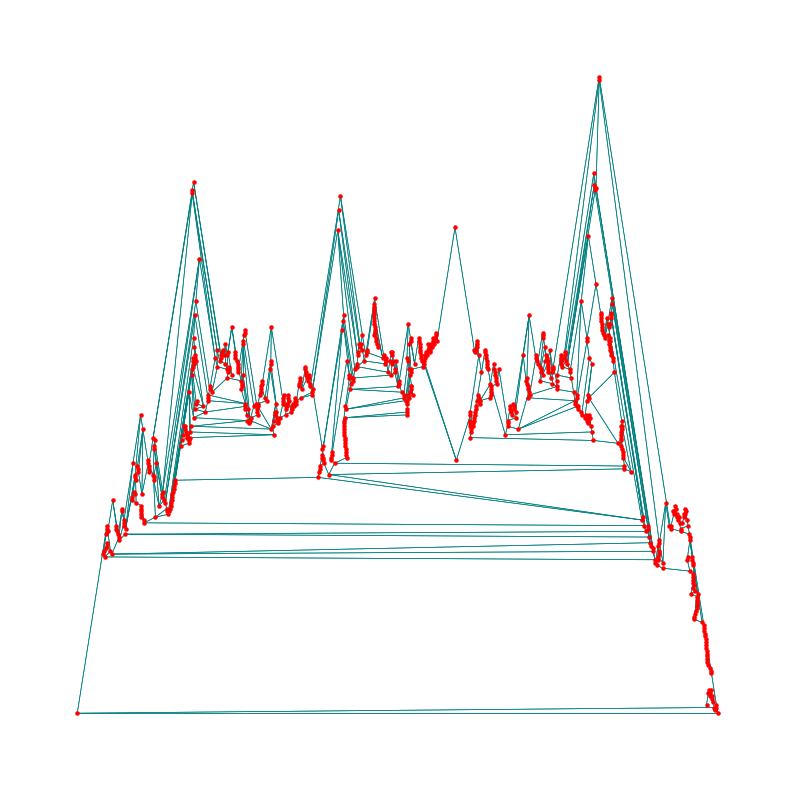

{'n': 715, 'm': 1652, 'k_avg': 4.620979020979021, 'edge_length_total': 109170.77000000003, 'edge_length_avg': 66.08400121065377, 'streets_per_node_avg': 2.6895104895104893, 'streets_per_node_counts': {0: 0, 1: 152, 2: 14, 3: 456, 4: 90, 5: 3}, 'streets_per_node_proportions': {0: 0.0, 1: 0.2125874125874126, 2: 0.019580419580419582, 3: 0.6377622377622377, 4: 0.1258741258741259, 5: 0.004195804195804196}, 'intersection_count': 563, 'street_length_total': 61383.27299999998, 'street_segment_count': 926, 'street_length_avg': 66.28863174946002, 'circuity_avg': 1.0282180128376803, 'self_loop_proportion': 0.0, 'node_density_km': 213.51895514844566, 'intersection_density_km': 168.1275129350698, 'edge_density_km': 32601.438801610184, 'street_density_km': 18330.758481890614}


1652

In [18]:
leeds_graph = osmnx.graph_from_polygon(leeds_polygon, network_type = 'drive')
planar, planar_example = nx.check_planarity(leeds_graph)
print('The network is planar:', planar)

fig,ax = plt.subplots(figsize=(10,10))
nx.draw(planar_example, pos=nx.planar_layout(planar_example), node_size=5, edge_color='teal', node_color='r', width=0.5, ax=ax)
plt.show()

In [ ]:
osmnx.plot_graph_folium(leeds_graph)

In [19]:
leeds_area = osmnx.project_gdf(leeds_center).unary_union.area
print(osmnx.basic_stats(leeds_graph, area=leeds_area))

x_values = nx.get_node_attributes(leeds_graph, 'x')
y_values = nx.get_node_attributes(leeds_graph, 'y')

# Get a list of edges with attributes
graph_edges = list(leeds_graph.edges(data=True))

# Add missing geometry to edges
for e in graph_edges:
    if not 'geometry' in e[2]:
        e[2]['geometry'] = LineString([Point(x_values[e[0]], y_values[e[0]]),Point(x_values[e[1]], y_values[e[1]])])

len(graph_edges)

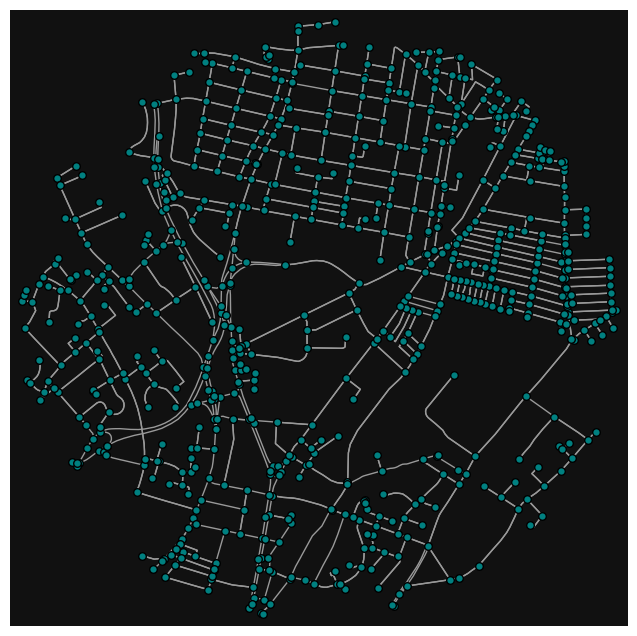

In [7]:
fig = osmnx.plot_graph(leeds_graph, node_color='teal', node_size=30, node_zorder=2, node_edgecolor='k')

In [8]:
#get shortest paths between all points on the graph
shortest_paths = []
for node in leeds_graph.nodes:
    node_path_lengths = nx.single_source_dijkstra_path_length(leeds_graph, node, weight='length')
    max_path_length = max(node_path_lengths.values())
    shortest_paths.append(max_path_length)

spatial_diameter = max(shortest_paths)
spatial_diameter

3804.313

In [9]:
# From Lab8 https://github.kcl.ac.uk/k2143309/7CUSMNDA-2023
leeds_roads = [x[2] for x in graph_edges]
# From this, we can construct a GeoDataFrame
leeds_road_gdf = GeoDataFrame(pd.DataFrame(leeds_roads))
leeds_road_gdf

osmid  oneway lanes  ref  \
0                             491178802    True     2  A61   
1                              53014871    True   NaN  NaN   
2                              23120678   False   NaN  NaN   
3                              38422455    True     2  A61   
4     [169591262, 440408598, 169591263]   False     2  NaN   
...                                 ...     ...   ...  ...   
1647                         1133776017    True   NaN  NaN   
1648                         1140215738   False   NaN  NaN   
1649                           23137264   False     2  NaN   
1650                           23091062   False     2  NaN   
1651                          149749869   False   NaN  NaN   

                     name       highway maxspeed reversed   length  \
0           Regent Street         trunk   30 mph    False   75.411   
1            Byron Street  unclassified   20 mph    False   78.630   
2            Skinner Lane      tertiary   30 mph     True   11.470   
3           Regent Street         trunk      NaN    False   67.194   
4            Skinner Lane      tertiary   30 mph    False  208.128   
...                   ...           ...      ...      ...      ...   
1647  Lascelles Road East   residential      NaN    False   10.172   
1648       Chapman Street  unclassified   20 mph     True    4.829   
1649           Cherry Row      tertiary   30 mph    False    4.397   
1650           Cherry Row      tertiary   30 mph     True  104.003   
1651      Mushroom Street  unclassified      NaN     True  151.062   

                                               geometry bridge junction access  
0     LINESTRING (-1.53312 53.80234, -1.53294 53.80301)    NaN      NaN    NaN  
1     LINESTRING (-1.53312 53.80234, -1.53321 53.802...    NaN      NaN    NaN  
2     LINESTRING (-1.53260 53.80366, -1.53276 53.80369)    NaN      NaN    NaN  
3     LINESTRING (-1.53260 53.80366, -1.53276 53.80306)    NaN      NaN    NaN  
4     LINESTRING (-1.53260 53.80366, -1.53252 53.803...    yes      NaN    NaN  
...                                                 ...    ...      ...    ...  
1647  LINESTRING (-1.51745 53.81399, -1.51741 53.813...    NaN      NaN    NaN  
1648  LINESTRING (-1.52390 53.80491, -1.52397 53.80490)    NaN      NaN    NaN  
1649  LINESTRING (-1.52867 53.80403, -1.52866 53.80407)    NaN      NaN    NaN  
1650  LINESTRING (-1.52867 53.80403, -1.52876 53.803...    NaN      NaN    NaN  
1651  LINESTRING (-1.52867 53.80403, -1.52919 53.804...    NaN      NaN    NaN  

[1652 rows x 13 columns]

In [10]:
# Construct a network in Spaghetti from which to do point analysis, using the GeoDataFrame
leeds_spagh_graph = spaghetti.Network(in_data=leeds_road_gdf)

In [11]:
# Snap the Leeds accident points to the closest road segment
leeds_spagh_graph.snapobservations(leeds_accident, 'accidents')

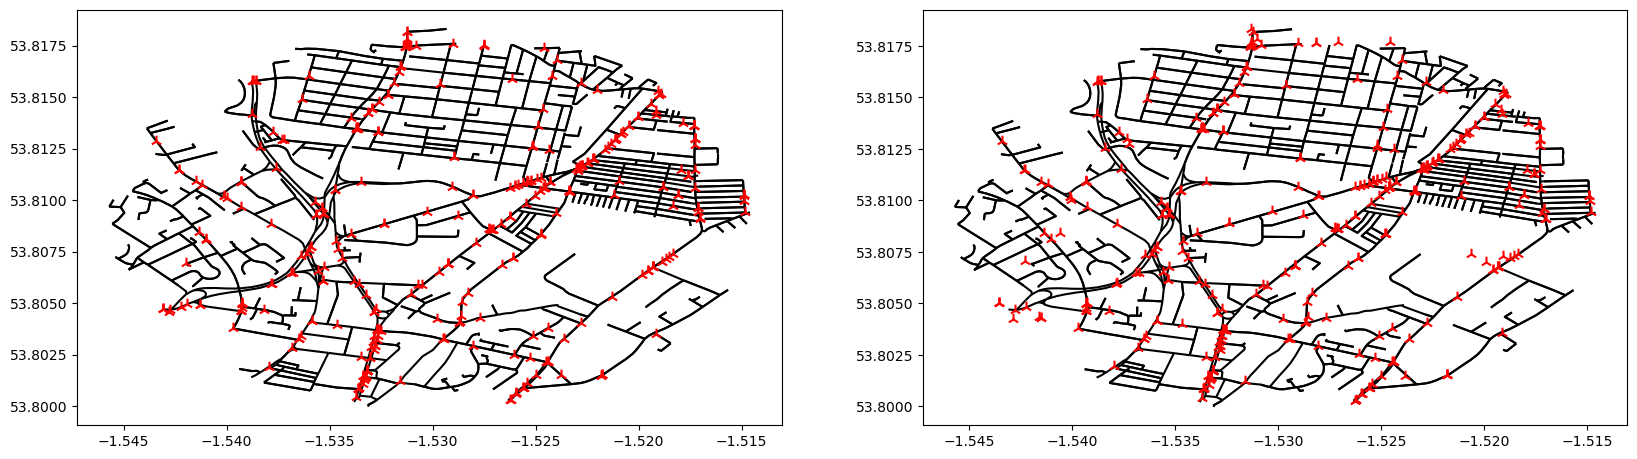

In [22]:
# Get a GeoDataFrame of the snapped accident locations to plot on the network image
observed_accidents=spaghetti.element_as_gdf(leeds_spagh_graph, pp_name='accidents', snapped=False)

snap_accident_points=spaghetti.element_as_gdf(leeds_spagh_graph, pp_name='accidents', snapped=True)

fig, axs = plt.subplots(1, 2, figsize=(20,40))

leeds_road_gdf.plot(color="k", zorder=0, ax=axs[0])
leeds_road_gdf.plot(color="k", zorder=0, ax=axs[1])

snap_accident_points.plot(color="r", marker="2", markersize=70, zorder=1, ax=axs[0])
observed_accidents.plot(color="r", marker="2", markersize=70, zorder=1, ax=axs[1])

plt.savefig('accidents-observations')
plt.show()

In [23]:
# From Lab8 https://github.kcl.ac.uk/k2143309/7CUSMNDA-2023
kres = leeds_spagh_graph.GlobalAutoK(leeds_spagh_graph.pointpatterns["accidents"],nsteps=100, permutations=100)

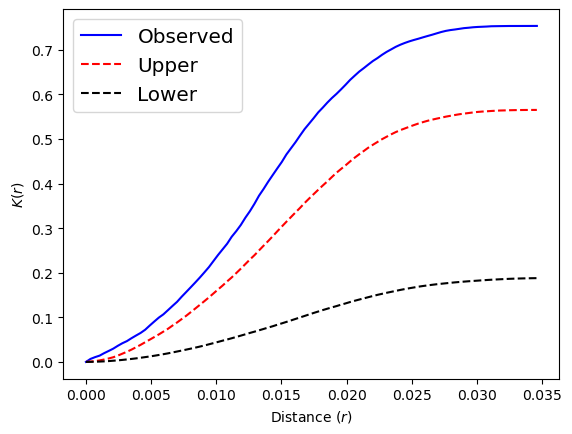

In [24]:
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

plt.show()

In [25]:
# Get snapped point pattern 
pointpat = leeds_spagh_graph.pointpatterns['accidents']
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_spagh_graph.count_per_link(pointpat.obs_to_arc, graph=False)
weights = leeds_spagh_graph.w_network

edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for _, edge in enumerate(edges)]

In [26]:
moran = esda.moran.Moran(values, weights)
print("Moran I = ", moran.I) 
print("Moran P-Si = ", moran.p_sim)
print("Moran EI = ", moran.EI)
print("Moran EI-Sim ", moran.EI_sim)
print("Moran Z-norm = ", moran.z_norm)
print("Moran Z-sim = ", moran.z_sim)


Moran I =  0.14857507925599178
Moran P-Si =  0.001
Moran EI =  -0.00039277297721916735
Moran EI-Sim  4.475280852184266e-05
Moran Z-norm =  8.332217752188214
Moran Z-sim =  8.308668502250947


Text(0.5, 0, "Moran's I")

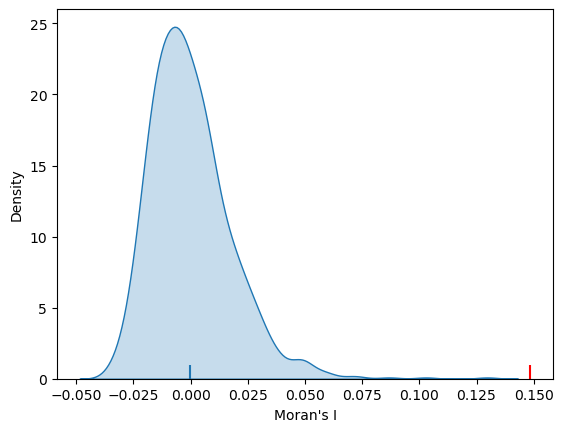

In [27]:
sns.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I")

Text(0, 0.5, 'Accident Spatial Lag (Mean Accidents)')

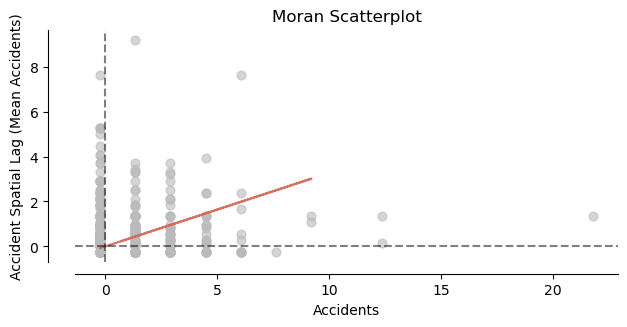

In [28]:
from splot.esda import moran_scatterplot
fig,ax = moran_scatterplot(moran, p=0.005)
ax.set_title("Moran Scatterplot")
ax.set_xlabel("Accidents")
ax.set_ylabel("Accident Spatial Lag (Mean Accidents)")

In [29]:
x_val = snap_accident_points.geometry.x
y_val = snap_accident_points.geometry.y

accident_street_pos = osmnx.nearest_edges(leeds_graph, x_val, y_val, interpolate=None, return_dist=False)

In [30]:
#compute fractions of street length that are closest to each accident point.
start_node_coords = np.array([(leeds_graph.nodes()[edge[0]]['y'], leeds_graph.nodes()[edge[0]]['x']) for edge in accident_street_pos])
end_node_coords = np.array([(leeds_graph.nodes()[edge[1]]['y'], leeds_graph.nodes()[edge[1]]['x']) for edge in accident_street_pos])
accident_pos = np.array([(y_val[i], x_val[i]) for i in range(len(accident_street_pos))])

street_lengths = np.array([haversine(end_node_coords[i], start_node_coords[i], unit='m') for i in range(len(accident_street_pos))])
accident_dists_start = np.array([haversine(accident_pos[i], start_node_coords[i], unit='m') for i in range(len(accident_street_pos))])
accident_dists_end = np.array([haversine(accident_pos[i], end_node_coords[i], unit='m') for i in range(len(accident_street_pos))])

fractions = np.where(accident_dists_start >= accident_dists_end, accident_dists_end / street_lengths, accident_dists_start / street_lengths)


0.13274580135155178


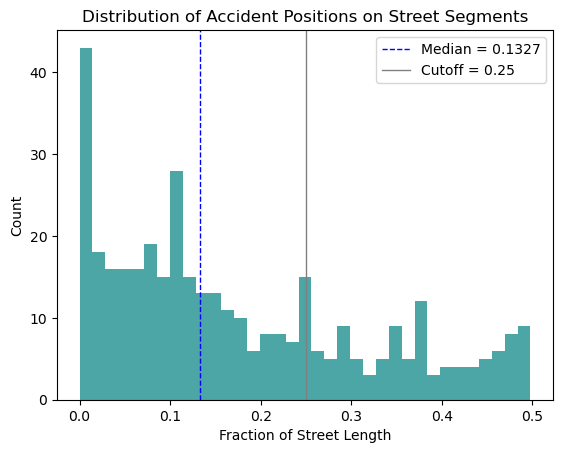

In [31]:
fig = sns.distplot(fractions, bins=35, kde=False, color='teal', hist_kws={'alpha': 0.7})
fig.set(xlabel='Fraction of Street Length', ylabel='Count', title='Distribution of Accident Positions on Street Segments')
median = np.median(fractions)
plt.axvline(median, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(0.25, color='gray', linestyle='-', linewidth=1)
fig.legend(labels=['Median = ' + str(round(median, 4)), 'Cutoff = 0.25'])
print(median)

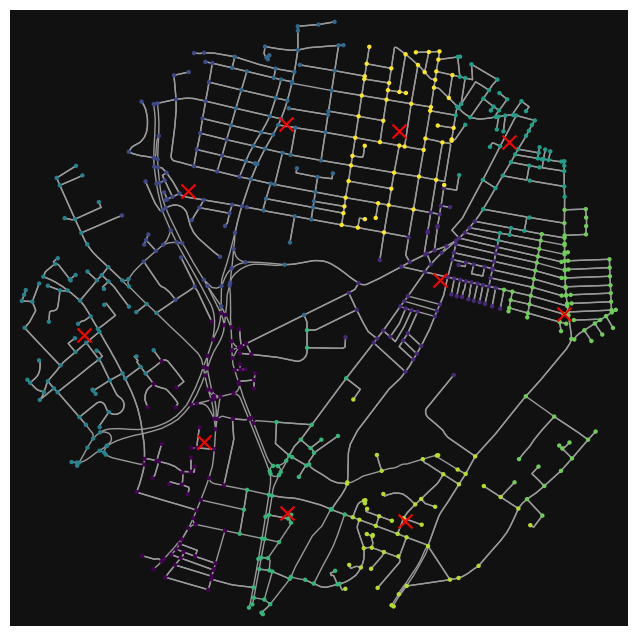

In [32]:
# leeds_city_graph = leeds_graph

# from sklearn.cluster import KMeans
# NUMBER_OF_SEEDS = 10
# all_nodes = list(leeds_city_graph.nodes(data=True))
# # Apply k-means++ algorithm with k = NUMBER_OF_SEEDS to the nodes in the graph using the latitude and longitude as the features
# kmeans = KMeans(init = 'k-means++', n_clusters=NUMBER_OF_SEEDS, n_init = "auto", random_state=42).fit([[node[1]['x'], node[1]['y']] for node in all_nodes])
# # Get the cluster labels for each node
# km_labels = kmeans.labels_
# #Return centroids of clusters
# centroids = kmeans.cluster_centers_
# # Plot the graph with the nodes coloured by cluster label, and the cluster centroids as red crosses
# fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=km_labels, node_size=10, node_zorder=2, show=False, close=False)
# ax.scatter(centroids[:,0], centroids[:,1], c='r', marker='x', s=100, zorder=3)
# plt.show()

In [52]:
PLACE_OF_INTEREST = "Leeds, UK"
leeds_city_graph = osmnx.graph_from_place(PLACE_OF_INTEREST,network_type = 'drive')

from sklearn.cluster import KMeans
NUMBER_OF_SEEDS = 10
all_nodes = list(leeds_city_graph.nodes(data=True))
#Apply k-means++ algorithm with k = NUMBER_OF_SEEDS to the nodes in the graph using the latitude and longitude as the features
kmeans = KMeans(init = 'k-means++', n_clusters=NUMBER_OF_SEEDS, n_init = "auto", random_state=42).fit([[node[1]['x'], node[1]['y']] for node in all_nodes])
#Return centroids of clusters
centroids = kmeans.cluster_centers_

In [53]:
seeds = [osmnx.distance.nearest_nodes(leeds_city_graph, *centroid) for centroid in centroids]
seeds

[395305638,
 317598135,
 6481110432,
 248497502,
 1955838372,
 380917738,
 1690928998,
 1580869371,
 305698610,
 1560077]

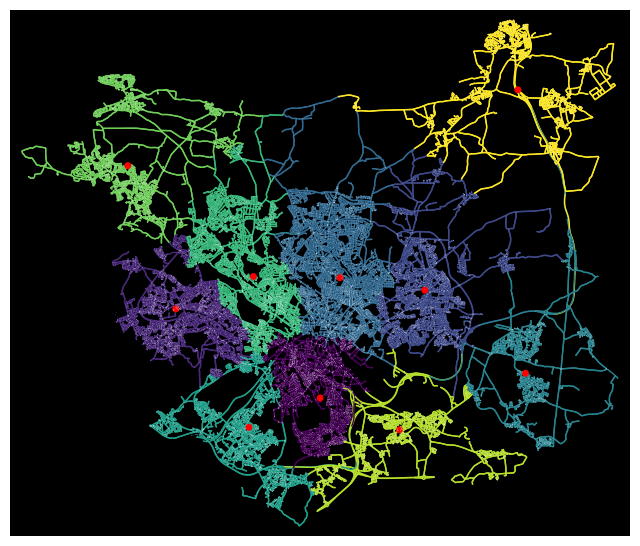

In [54]:
# From Lab6 https://github.kcl.ac.uk/k2143309/7CUSMNDA-2023
distances = {seed: nx.single_source_dijkstra_path_length(
    leeds_city_graph, seed, weight='length') for seed in seeds}

def nearest_from_list(node_distances):
    return sorted(node_distances, key=lambda node_length: node_length[1])[0] \
        if len(node_distances) > 0 else None

def nearest_seed(node):
    seed_distances = [(seed, distances[seed][node]) \
        for seed in seeds if node in distances[seed]]
    return nearest_from_list(seed_distances)

def nearest_for_edge(edge):
    nearest_to_ends_all = [nearest_seed(edge[0]), nearest_seed(edge[1])]
    nearest_to_ends = [distance for distance in nearest_to_ends_all if distance]
    return nearest_from_list(nearest_to_ends)

colours = osmnx.plot.get_colors(NUMBER_OF_SEEDS)

def colour_for_seed_distance(seed):
    return colours[seeds.index(seed[0])]

edge_nearest_seeds = [nearest_for_edge(edge) for edge in leeds_city_graph.edges]
# Note that edges not connected to a seed shown in black, so invisible on black background
edge_colours = [colour_for_seed_distance(seed) if seed else 'k' for seed in edge_nearest_seeds]
# edge_colours = np.array(edge_colours, dtype=object)
# For the road network nodes, we want the seeds to be coloured red and the non-seed nodes to be coloured white.
all_nodes = list(leeds_city_graph.nodes())
node_colours = ['r' if node in seeds else 'w' for node in all_nodes]
node_size = [25 if node in seeds else 0.1 for node in all_nodes]

# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
osmnx.plot.plot_graph(leeds_city_graph, edge_color = edge_colours, node_size = node_size, bgcolor = 'k', node_color = node_colours)
plt.show()

In [55]:
#dict to encode the colours
colour_set = list(set(edge_colours))
#sort so k is last
k_index = colour_set.index("k")
k_val = colour_set.pop(k_index)
colour_set.append(k_val)
colour_dict = {colour: i for i, colour in enumerate(colour_set)}
for i, (u,v,k) in enumerate(leeds_city_graph.edges):
    leeds_city_graph.edges[u,v,k]['color_code'] = colour_dict[edge_colours[i]]

In [56]:
sub_graphs = []
for i in range(NUMBER_OF_SEEDS+1):
    sub_graph_edges = []
    for u,v,k in leeds_city_graph.edges:
        if leeds_city_graph.edges[u,v,k]['color_code'] == i:
            sub_graph_edges.append((u,v,k))
    subgraph = leeds_city_graph.edge_subgraph(sub_graph_edges)
    sub_graphs.append(subgraph)

seed_graphs = sub_graphs

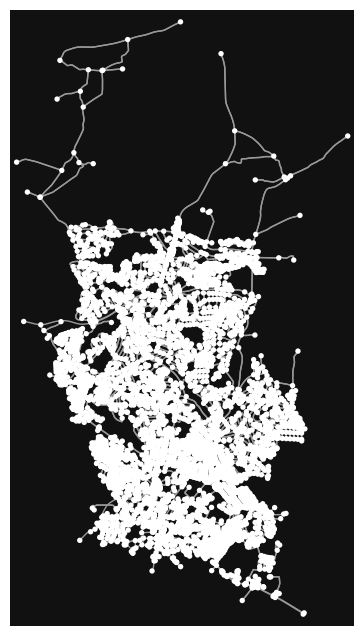

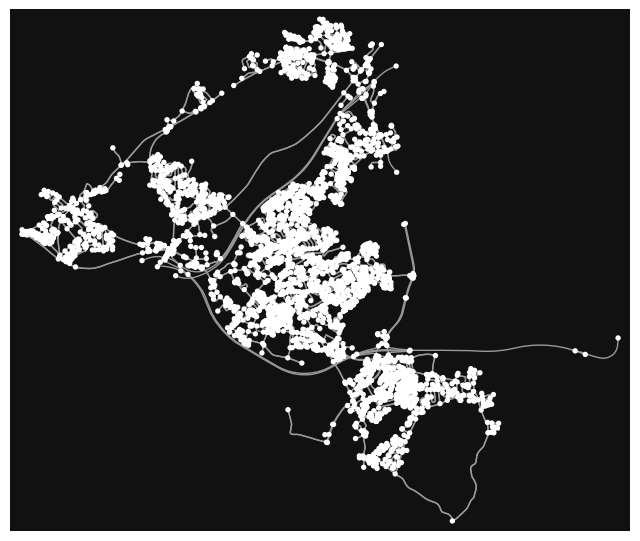

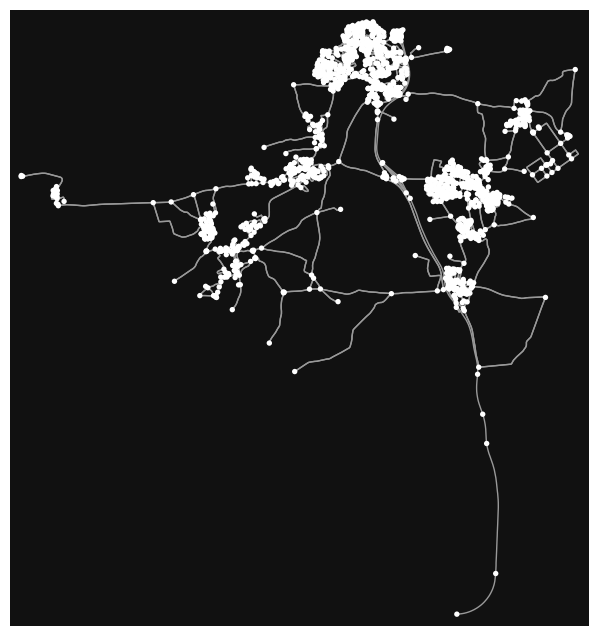

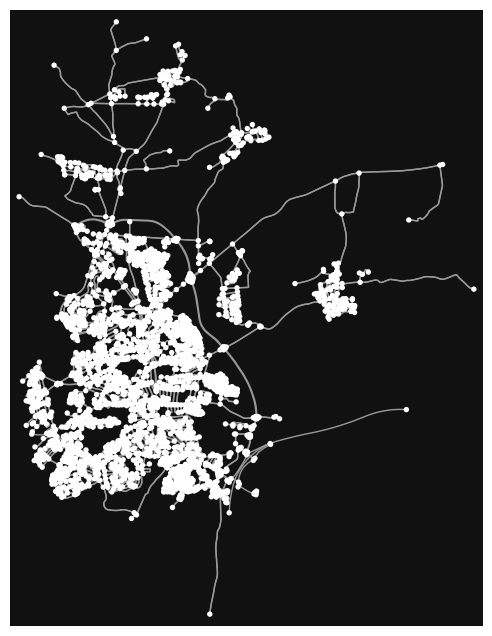

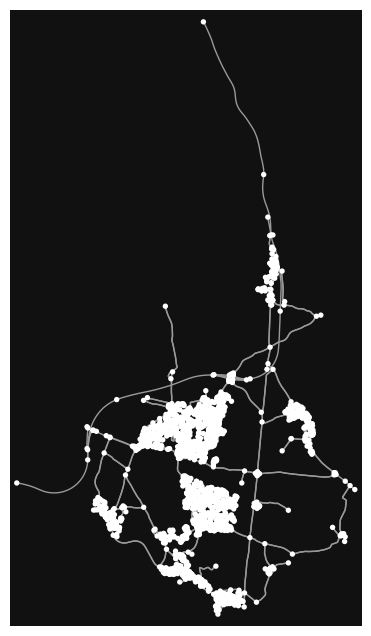

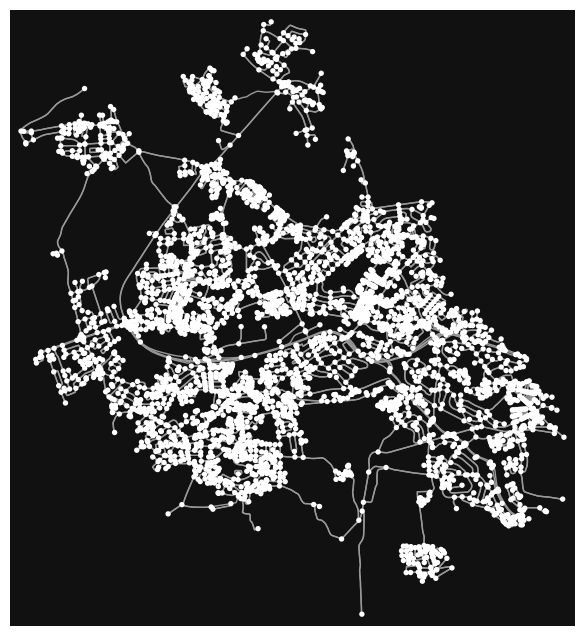

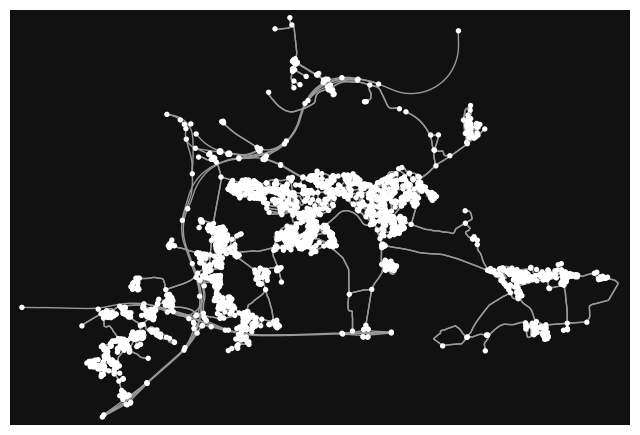

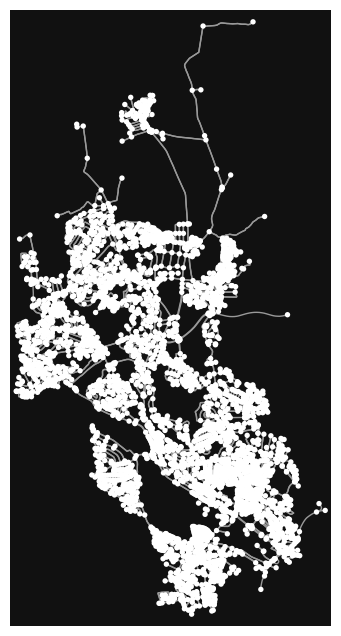

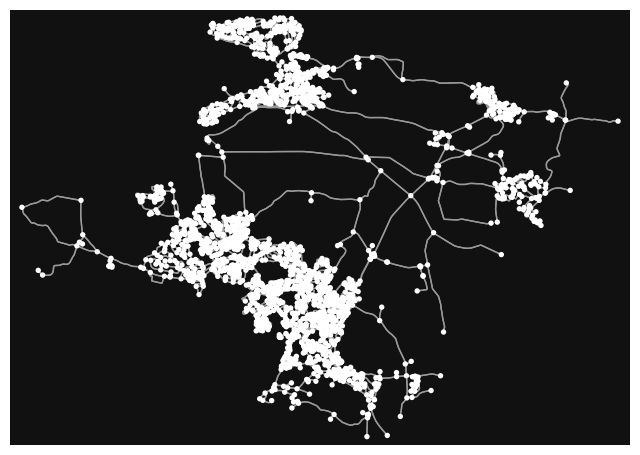

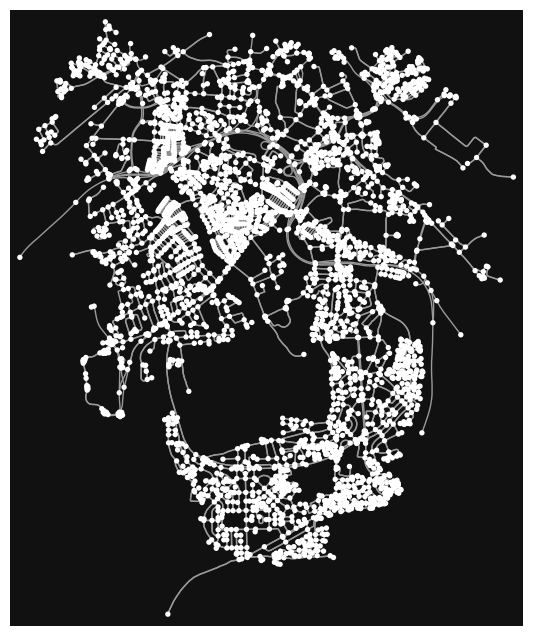

In [57]:
for i in range(NUMBER_OF_SEEDS):
    osmnx.plot.plot_graph(seed_graphs[i])

In [58]:
def get_path(seed_graph, starting_node):
    current_node = starting_node
    path_lengths = []
    traversal_path = []
    previous_node = ""
    while sum(path_lengths) < 21000:
        try:
            paths_lengths = nx.single_source_dijkstra_path_length(seed_graph, current_node, weight='length')
            sorted_lengths = sorted(paths_lengths.items(), key=lambda item: item[1], reverse=True)
            sorted_nodes = [node for node, length in sorted_lengths if node != previous_node]
            max_node = sorted_nodes[0]
            path_lengths.append(paths_lengths[max_node])
            while sum(path_lengths) > 21000:
                path_lengths = path_lengths[:-1]
                max_node = sorted_nodes[1]
                sorted_nodes = sorted_nodes[1:]
                path_lengths.append(paths_lengths[max_node])
            paths = nx.dijkstra_path(seed_graph, current_node, max_node, weight='length')
            traversal_path = traversal_path[:-1] + paths
            previous_node = current_node
            current_node = max_node
        except (IndexError, KeyError):
            print("No exact path found using this starting node, closest path found is: ", sum(path_lengths))
            break
    return traversal_path, sum(path_lengths)

In [59]:
# Find paths using random starting nodes (works for paths 0, 3-9)
seed_graph_starting_nodes = []
no_paths_found = []
p_length = 0
counter = 0
for i in range(0, NUMBER_OF_SEEDS):
    print(i)
    while p_length < 20950:
        seed_node = random.choice(list(seed_graphs[i].nodes))
        t_path,p_length = get_path(seed_graphs[i], seed_node)
        start_node = t_path[0]
        counter += 1
        if counter > 100:
            no_paths_found.append(i)
            break
    counter = 0
    p_length = 0
    seed_graph_starting_nodes.append(start_node)
print(no_paths_found)

0
No exact path found using this starting node, closest path found is:  20888.127
No exact path found using this starting node, closest path found is:  20946.878
No exact path found using this starting node, closest path found is:  20959.839
1
No exact path found using this starting node, closest path found is:  11823.866999999998
No exact path found using this starting node, closest path found is:  12268.37
No exact path found using this starting node, closest path found is:  9442.403999999999
No exact path found using this starting node, closest path found is:  10695.599999999995
No exact path found using this starting node, closest path found is:  12480.321999999998
No exact path found using this starting node, closest path found is:  11905.246
No exact path found using this starting node, closest path found is:  11783.528999999997
No exact path found using this starting node, closest path found is:  10532.428999999996
No exact path found using this starting node, closest path found

In [40]:
# # Brute force testing every node as a starting node (works for paths 1 and 2)
# path_length_pairs = []
# for seed_node in seed_graphs[2].nodes:
#     t_path,p_length = get_path(seed_graphs[2], seed_node)
#     start_node = t_path[0]
#     path_length_pairs.append((start_node, p_length))

In [41]:
# # City center starting nodes
# starting_node_list = seed_graph_starting_nodes

In [60]:
# Whole city starting nodes
starting_node_list = [3181253378, 364384983, 1985025822, 690265820, 6784998070, 317600313, 1715201705, 21428171, 27563136, 250074116]

In [43]:
# #Checking paths to troubleshooting
# print(path_length_pairs)
# path_length_pairs.sort(key=lambda x: x[1], reverse=True)

#filter for values between 10000 and 11000
# filtered_pairs = [x for x in path_length_pairs if x[1] > 10490 and x[1] < 10510]
# filtered_pairs

In [61]:
marathon_paths = []
marathon_lengths = []
for i, starting_node in enumerate(starting_node_list):
    t_path,p_length = get_path(seed_graphs[i], starting_node)
    marathon_paths.append(t_path)
    marathon_lengths.append(p_length)

No exact path found using this starting node, closest path found is:  20420.914999999997
No exact path found using this starting node, closest path found is:  10499.439999999997
No exact path found using this starting node, closest path found is:  20553.784
No exact path found using this starting node, closest path found is:  20999.464
No exact path found using this starting node, closest path found is:  20973.500000000004
No exact path found using this starting node, closest path found is:  20977.270000000004
No exact path found using this starting node, closest path found is:  20997.48
No exact path found using this starting node, closest path found is:  20992.232
No exact path found using this starting node, closest path found is:  20988.361000000004
No exact path found using this starting node, closest path found is:  20999.372


In [62]:
# #  Compute Alternate Path for Full Leed Graph Marathon Path 2
# print(marathon_paths[2])
# # Compute fraction from starting node of marathon path 2
# check_lengths = nx.single_source_dijkstra_path_length(seed_graphs[2], 765227730, weight='length')
# print(seed_graphs[2].edges(765227730))
# # [(765227730, 765229124), (765227730, 21436381), (765227730, 765234932)]
# check_lengths[21436381]
# test_path_2 = marathon_paths[2][3:]
# test_path_2.insert(0, 21436381)
# # test_path.insert(0, 495969140)

# #compute path length
# def compute_path_length(test_path, test_graph):
#     path_length = 0
#     for i in range(len(test_path)-1):
#         path_length += test_graph.edges[test_path[i], test_path[i+1],0]['length']
#     return path_length


# partial_path_length = compute_path_length(test_path_2[1:], seed_graphs[2])
# single_path_length = compute_path_length(test_path_2[:2], seed_graphs[2])
# required_path_length = 21000 - partial_path_length
# print("Starting Node", test_path_2[0])
# print("Starting Edge", test_path_2[:2])
# edge_fraction = required_path_length/single_path_length
# print("Fraction of starting Edge required", edge_fraction)
# print("Distance from Starting Node where Start should be", single_path_length - single_path_length*edge_fraction)

# marathon_paths[2] = test_path_2

# osmnx.folium.plot_route_folium(leeds_city_graph, test_path_2, route_color='r', node_size = 0, route_linewidth=6)

[1985025822, 765227720, 765229124, 765227730, 765234932, 21436395, 373372258, 27456692, 21436397, 367293090, 1581058352, 798056773, 1652885241, 26261624, 907813435, 907813515, 248091811, 248091812, 907813493, 907813314, 389906705, 907813348, 907813331, 907813436, 26261629, 26261630, 27480801, 13807346, 798122888, 798155388, 907813562, 2049640597, 1984729084, 277967129, 2050307361, 277967121, 277967122, 1581182921, 1581182854, 1581182956, 1581182906, 1581183030, 1581183038, 1554569, 1554000, 1553845, 1553614, 319599]
[(765227730, 765229124), (765227730, 21436381), (765227730, 765234932)]
Starting Node 21436381
Starting Edge [21436381, 765227730]
Fraction of starting Edge required 0.43128139675447513
Distance from Starting Node where Start should be 792.2580000000044


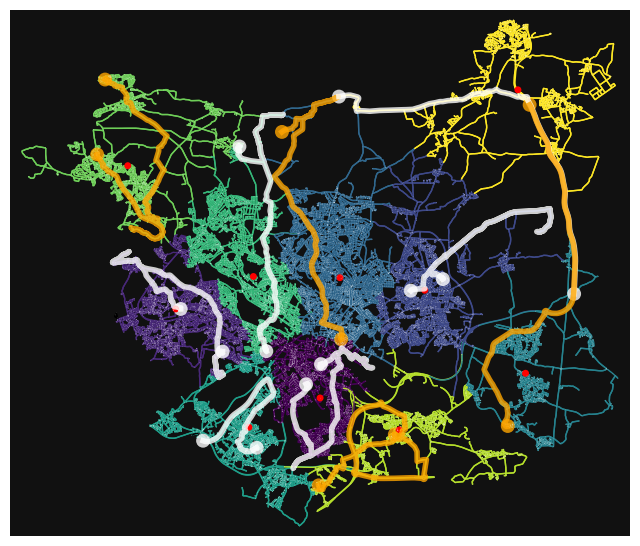

In [63]:
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=node_colours, edge_color=edge_colours, node_size=node_size, node_zorder=2, show=False, close=False)
osmnx.plot.plot_graph_routes(leeds_city_graph, marathon_paths, route_colors=['orange','w','w','w','orange','w','orange','w','orange','w'], route_linewidth=3, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
# osmnx.plot.plot_graph_route(leeds_city_graph, removed_path, route_color='r', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax)
plt.show()

In [64]:
def find_cycle_paths(seed_graph):
    basic_directed_g = nx.Graph(seed_graph)
    base_cycles = nx.cycle_basis(basic_directed_g, root=None)

    cycles = []
    lengths = []
    length = 0
    for cycle in base_cycles:
        for i in range(len(cycle)-1):
            length += basic_directed_g.edges[cycle[i], cycle[i+1]]['length']
        lengths.append(length)
        cycles = cycle + [cycle[0]]
        length = 0

    cycle_lengths = zip(base_cycles, lengths)

    cycle_lengths = sorted(cycle_lengths, key=lambda x: x[1], reverse=True)

    filtered_cycles = []
    for min_length, max_length in [(41500, 42500), (20750, 21250), (10375, 10675)]:
        filtered = [x for x in cycle_lengths if min_length < x[1] < max_length]
        if filtered:
            filtered_cycles = filtered
            break

    return filtered_cycles

none_found = []
marathon_paths2 = []
marathon_lengths2 = []
for i in range(NUMBER_OF_SEEDS):
    try:
        test_path, test_length = find_cycle_paths(seed_graphs[i])[0]
        marathon_paths2.append(test_path)
        marathon_lengths2.append(test_length)
    except(IndexError):
        none_found.append(i)
        marathon_paths2.append(None)
        marathon_lengths2.append(None)

print(none_found)
marathon_lengths2

[1, 4, 6]


[41663.872,
 None,
 21144.316999999995,
 20858.002,
 None,
 10541.261999999999,
 None,
 10475.029000000006,
 10622.593999999997,
 41727.35799999998]

In [65]:
cycles_dist = []

def find_cycles(seed_graphs):
    for cycle in nx.simple_cycles(seed_graphs):
        distance = 0
        for i in range(len(cycle)-1):
            distance += seed_graphs.edges[cycle[i], cycle[i+1],0]['length']
        if (distance > 41500 and distance < 42500):
            return cycle, distance

for i in [4,6]:
    cycle, distance = find_cycles(seed_graphs[i])
    cycles_dist.append((cycle, distance))
    
distances = [dist for cycl,dist in cycles_dist]
marathon_paths3 = [cycl for cycl,dist in cycles_dist]


In [67]:
distances

[42108.459, 41506.712999999945]

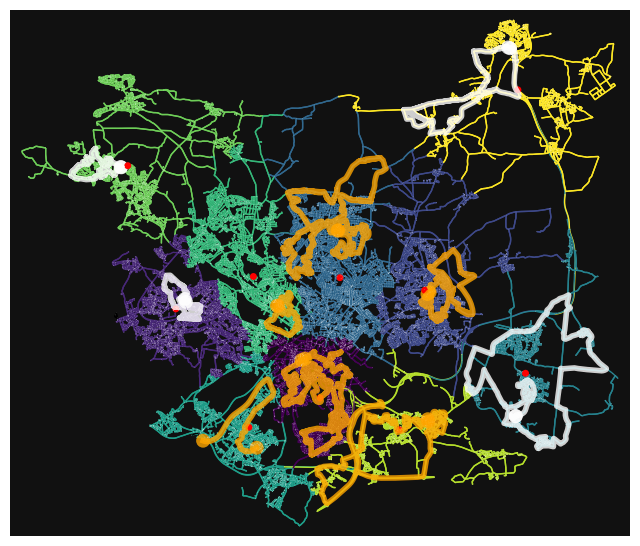

In [66]:
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
marathon_paths2 = [x for x in marathon_paths2 if x is not None]
leeds_city = leeds_city_graph.to_undirected()
# Plot the Voronoi diagram with 10 seed points and 10 cells (one for each seed point)
fig, ax = osmnx.plot_graph(leeds_city_graph, node_color=node_colours, edge_color=edge_colours, node_size=node_size, node_zorder=2, show=False, close=False)
osmnx.plot.plot_graph_route(leeds_city_graph, marathon_paths[1], route_color='orange', route_linewidth=4, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
osmnx.plot.plot_graph_routes(leeds_city, marathon_paths2, route_colors=['orange','w', 'orange','w', 'orange','w', 'orange'], route_linewidth=0.5, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
osmnx.plot.plot_graph_routes(leeds_city_graph, marathon_paths3, route_colors=["w","orange"], route_linewidth=0.5, node_size=0, route_alpha=0.8, bgcolor='k', ax=ax, show=False, close=False)
# osmnx.plot.plot_graph_route(leeds_city_graph, removed_path, route_color='r', route_linewidth=3, node_size=0, route_alpha=0.4, bgcolor='k', ax=ax)
plt.show()